In [0]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_iris, load_boston, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline 
sns.set(style="ticks")


In [0]:
wine = load_wine()

In [0]:
# Сформируем DataFrame
wine_df = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= list(wine['feature_names']) + ['target'])

In [47]:
wine_df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [48]:
wine_df.head

<bound method NDFrame.head of      alcohol  malic_acid   ash  ...  od280/od315_of_diluted_wines  proline  target
0      14.23        1.71  2.43  ...                          3.92   1065.0     0.0
1      13.20        1.78  2.14  ...                          3.40   1050.0     0.0
2      13.16        2.36  2.67  ...                          3.17   1185.0     0.0
3      14.37        1.95  2.50  ...                          3.45   1480.0     0.0
4      13.24        2.59  2.87  ...                          2.93    735.0     0.0
..       ...         ...   ...  ...                           ...      ...     ...
173    13.71        5.65  2.45  ...                          1.74    740.0     2.0
174    13.40        3.91  2.48  ...                          1.56    750.0     2.0
175    13.27        4.28  2.26  ...                          1.56    835.0     2.0
176    13.17        2.59  2.37  ...                          1.62    840.0     2.0
177    14.13        4.10  2.74  ...                      

In [0]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
# Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [0]:
bin_wine_y = convert_target_to_binary(wine.target, 2)

In [0]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, bin_wine_y, test_size=0.2, random_state=1)

In [0]:
cl1 = LogisticRegression()

In [53]:
cl1.fit(wine_X_train, wine_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
pred_wine_y_test = cl1.predict(wine_X_test)
pred_wine_y_test

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])

In [55]:
pred_wine_y_test_proba = cl1.predict_proba(wine_X_test)
pred_wine_y_test_proba[:10]

array([[6.68079892e-02, 9.33192011e-01],
       [9.99028207e-01, 9.71793439e-04],
       [9.98580107e-01, 1.41989333e-03],
       [9.99003796e-01, 9.96204381e-04],
       [9.88936974e-01, 1.10630263e-02],
       [4.53886820e-02, 9.54611318e-01],
       [9.54965154e-01, 4.50348464e-02],
       [9.98955910e-01, 1.04409049e-03],
       [7.08706358e-03, 9.92912936e-01],
       [9.68840863e-01, 3.11591369e-02]])

In [56]:
# Вероятность принадлежности к 0 классу
[round(x, 4) for x in pred_wine_y_test_proba[:10,0]]

[0.0668, 0.999, 0.9986, 0.999, 0.9889, 0.0454, 0.955, 0.999, 0.0071, 0.9688]

In [57]:
# Вероятность принадлежности к 1 классу
[round(x, 4) for x in pred_wine_y_test_proba[:10,1]]

[0.9332, 0.001, 0.0014, 0.001, 0.0111, 0.9546, 0.045, 0.001, 0.9929, 0.0312]

In [58]:
# Сумма вероятностей равна 1
pred_wine_y_test_proba[:10,0] + pred_wine_y_test_proba[:10,1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [59]:
accuracy_score(wine_y_test, pred_wine_y_test)

0.9722222222222222

In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [61]:
print_accuracy_score_for_classes(wine_y_test, pred_wine_y_test)

Метка 	 Accuracy
0 	 1.0
1 	 0.8888888888888888


In [0]:
wine_X = wine.data[:, :2]
wine_y = wine.target

In [0]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(wine_X, wine_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = wine_X[:, 0], wine_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=wine_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [0]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.2, random_state=1)

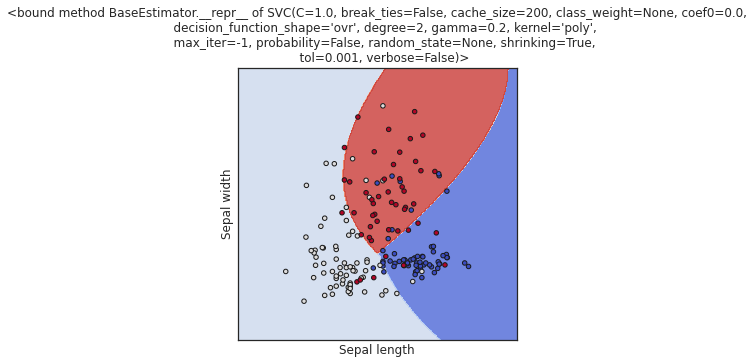

In [65]:
plot_cl(SVC(kernel='poly', degree=2, gamma=0.2, C=1.0))

In [0]:
svc = SVC(kernel='poly', degree=2, gamma=0.4, C=1.2).fit(wine_X_train, wine_y_train) 
target_svc = svc.predict(wine_X_test)

In [67]:
accuracy_score(wine_y_test, target_svc)

0.9722222222222222

In [0]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = len(np.unique(ds.target))
    plot_colors = "ryb"
    plot_step = 0.02
    
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = ds.data[:, pair]
        y = ds.target

        # Train
        clf = DecisionTreeClassifier(random_state=1).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(ds.feature_names[pair[0]])
        plt.ylabel(ds.feature_names[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=ds.target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show()

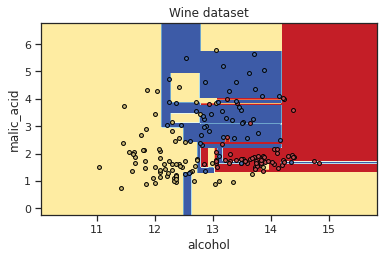

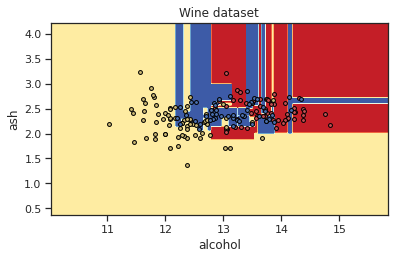

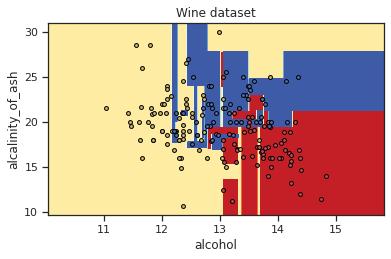

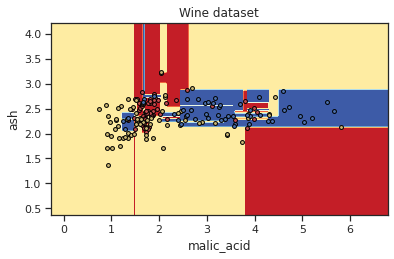

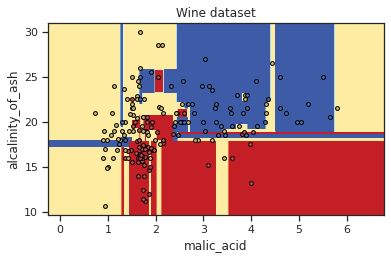

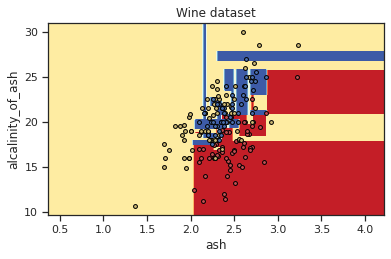

In [69]:
plot_tree_classification('Wine dataset', wine)

In [70]:
wine_x_ds = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])
wine_x_ds.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [71]:
# Обучим дерево на всех признаках wine
wine_tree_cl = DecisionTreeClassifier(random_state=2)
wine_tree_cl.fit(wine_x_ds, wine.target)
wine_tree_cl

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best')

In [72]:
# Важность признаков
list(zip(wine_x_ds.columns.values, wine_tree_cl.feature_importances_))

[('alcohol', 0.026793723850009183),
 ('malic_acid', 0.0),
 ('ash', 0.0),
 ('alcalinity_of_ash', 0.0),
 ('magnesium', 0.0),
 ('total_phenols', 0.0),
 ('flavanoids', 0.1414466773122087),
 ('nonflavanoid_phenols', 0.0),
 ('proanthocyanins', 0.0),
 ('color_intensity', 0.058580132648368075),
 ('hue', 0.058185091460406506),
 ('od280/od315_of_diluted_wines', 0.3120425747831769),
 ('proline', 0.4029517999458307)]

In [73]:
# Важность признаков в сумме дает единицу
sum(wine_tree_cl.feature_importances_)

1.0

In [0]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

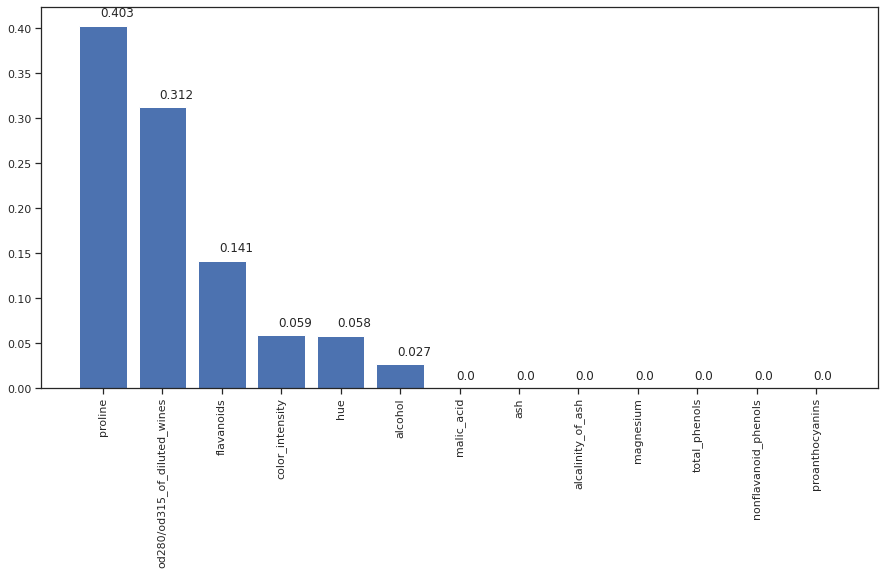

In [75]:
wine_tree_cl_fl, wine_tree_cl_fd = draw_feature_importances(wine_tree_cl, wine_x_ds)

In [76]:
# Список признаков, отсортированный на основе важности, и значения важности
wine_tree_cl_fl, wine_tree_cl_fd

(['proline',
  'od280/od315_of_diluted_wines',
  'flavanoids',
  'color_intensity',
  'hue',
  'alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'nonflavanoid_phenols',
  'proanthocyanins'],
 [0.4029517999458307,
  0.3120425747831769,
  0.1414466773122087,
  0.058580132648368075,
  0.058185091460406506,
  0.026793723850009183,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [77]:
wine_x_ds.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [80]:
# Пересортируем признаки на основе важности
wine_x_ds_sorted = wine_x_ds[wine_tree_cl_fl]
wine_x_ds_sorted.head()

,proline,od280/od315_of_diluted_wines,flavanoids,color_intensity,hue,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,nonflavanoid_phenols,proanthocyanins
0,1065.0,3.92,3.06,5.64,1.04,14.23,1.71,2.43,15.6,127.0,2.80,0.28,2.29
1,1050.0,3.40,2.76,4.38,1.05,13.20,1.78,2.14,11.2,100.0,2.65,0.26,1.28
2,1185.0,3.17,3.24,5.68,1.03,13.16,2.36,2.67,18.6,101.0,2.80,0.30,2.81
3,1480.0,3.45,3.49,7.80,0.86,14.37,1.95,2.50,16.8,113.0,3.85,0.24,2.18
4,735.0,2.93,2.69,4.32,1.04,13.24,2.59,2.87,21.0,118.0,2.80,0.39,1.82


In [81]:
# Разделим выборку на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_x_ds_sorted, wine.target, test_size=0.5, random_state=1)
wine_X_train.shape, wine_X_test.shape

((89, 13), (89, 13))

In [82]:
# Обучим дерево и предскажем результаты на всех признаках 
wine_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(wine_X_train, wine_y_train)
wine_y_test_predict = wine_tree_cl_feat_1.predict(wine_X_test)
wine_y_test_predict.shape

(89,)

In [83]:
# Проверим точность по классам
print_accuracy_score_for_classes(wine_y_test, wine_y_test_predict)

Метка 	 Accuracy
0 	 0.7878787878787878
1 	 0.7941176470588235
2 	 0.9545454545454546
